# Selección de clientes HybridFL - Método basado en recursos

En este notebook vamos a entrenar un modelo de ML utilizando el paradigma de Aprendizaje Federado [1] para los problemas de clasificación de dígitos manuscritos MNIST [2] y clasificación de imágenes a color CIFAR-10 [3]. Usaremos estos dos problemas de visión por computador para la implementación y análisis de rendimiento del método de selección de clientes basado en recursos HybridFL [4].
> [1] https://arxiv.org/abs/1602.05629
>
> [2] http://yann.lecun.com/exdb/mnist
>
> [3] https://www.cs.toronto.edu/~kriz/cifar.html
>
> [4] https://arxiv.org/abs/1905.07210

In [ ]:
# install FLEXible framework if not installed
try:
    import flex
    print("FLEXible is installed.")
except:
    print("FLEXible is not installed.\nInstalling dependency flexible-fl...")
    !pip install flexible-fl

FLEXible is not installed.
Installing dependency flexible-fl...
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.8/85.8 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.7/229.7 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.7 MB/s eta 0:00:00
  Created wheel for cardinality: filename=cardinality-0.1.1-py3-none-any.whl size=2588 sha256=68ebe84a8b4a273313ba8d33bdfc4a98ff68cdb6e4bba612f39a37d0692fe362
  Stored in directory: /root/.cache/pip/wheels/b8/19/d1/2665c004b583a7d1880fa59055a3e462d6e35841a01b57010b
Successfully built cardinality


In [ ]:
import matplotlib.pyplot as plt

def plot_loss_accuracy(loss, accuracy, title="Learning Curves"):
    # Example data
    epochs = range(1, len(loss) + 1)

    # Plot loss
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'b', label='Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, 'g', label='Accuracy')
    plt.title("Accuracy over Epochs")
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.suptitle(title)

    # Show the plots
    plt.tight_layout()
    plt.show()

In [ ]:
import torch

# select device
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)
device

'cpu'

# Cargar datasets - MNIST, CIFAR-10

Cargaremos $2$ de los datasets que usaremos para entrenar el modelo de ML.

## MNIST
El primero será MNIST (Modified National Institute of Standards and Technology database), que consiste en imágenes de $28$ pixeles de ancho y alto en escala de grises de dígitos manuscritos del $0$ al $9$. Formalmente, definimos el problema de ML como un problema de clasificación multiclase, donde definimos una imagen de entrada $X_n \in \mathcal X$ se define como una matriz $X_{28\times 28}, x_i \in \{1, ..., 255\}$, donde $x_i$ es un pixel de la imagen $X$. Cada imágen de entrada $X_n\in \mathcal X$ es etiquetada con una clase $y_n \in \mathcal Y, y = \{0, 1, ..., 9\}$ que representa el dígito al que corresponde la imagen. El conjunto de entrenamiento consta de $N=240,000$ imágenes.

El dataset descargado será el de _Extended MNIST_ [1], que comprende una versión extendida del concepto original de MNIST para proporcionar dígitos y letras manuscritas, una cantidad más grande de datos, diferentes formas de separar los datos (solo dígitos, letras, por clase, ...), etc. Nosotros solo utilizaremos los dígitos para entrenar el clásico MNIST, del cual su versión extendida consta de $N = 280,000$ imágenes de dígitos manuscritos.

Una característica importante de EMNIST es que cada imagen tendrá asociado un autor (i.e. la persona que ha escrito el dígito o letra), tal que un dígito es escrito por un solo autor pero un autor puede escribir muchos dígitos. Esto nos da la ventaja de poder distribuir los datos de forma No-IID tal que cada cliente tendrá los datos con autoría de un solo autor.

FLEX nos da utilidades para cargar EMNIST y federarlo automáticamente con la función `load`, donde además descargamos el dataset de test y solo usaremos el dataset de dígitos clásico de MNIST. Definimos también las transformaciones a realizar a los datos que son simplemente normalizar cada pixel a valores de $[0,1]$ (función `ToTensor()`) y normalizar los valores de cada pixel con una media y desviación estándar de $0.5$.

> [1] https://www.nist.gov/itl/products-and-services/emnist-dataset

In [ ]:
from flex.datasets import load
from flex.datasets.standard_datasets import emnist
from torchvision import transforms

flex_dataset_mnist, test_data = load("federated_emnist", return_test=True, split="digits")

# Assign test data to server_id
server_id = "server"
flex_dataset_mnist[server_id] = test_data

# apply transforms
mnist_transforms = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

Downloading...
From (original): https://drive.google.com/uc?id=1fl9fRPPxTUxnC56ACzZ8JiLiew0SMFwt
From (redirected): https://drive.google.com/uc?id=1fl9fRPPxTUxnC56ACzZ8JiLiew0SMFwt&confirm=t&uuid=d2839a9f-4707-4ac7-8568-c4b99b90b5d0
To: /content/emnist-digits.mat
100%|██████████| 90.7M/90.7M [00:04<00:00, 20.9MB/s]
[sultan]: md5 -q ./emnist-digits.mat;
DEBUG:sultan:md5 -q ./emnist-digits.mat;
[sultan]: Unable to run 'md5 -q ./emnist-digits.mat;'
CRITICAL:sultan:Unable to run 'md5 -q ./emnist-digits.mat;'
[sultan]: --{ TRACEBACK }----------------------------------------------------------------------------------------------------
CRITICAL:sultan:--{ TRACEBACK }----------------------------------------------------------------------------------------------------
[sultan]: | NoneType: None
CRITICAL:sultan:| NoneType: None
[sultan]: | 
CRITICAL:sultan:| 
[sultan]: -------------------------------------------------------------------------------------------------------------------
CRITICAL:sulta

## CIFAR-10

El segundo dataset es CIFAR-10 (_Canadian Institute for Advanced Research_)[1], el cual es otro de los datasets junto con MNIST, más utilizados en el campo del Deep Learning y Visión por Computador. CIFAR-10 consiste en una colección de imágenes de $32$ pixeles de altura y de ancho a color ($3$ canales RGB) representando $10$ objetos reales:
- Avión (airplane)
- Automóvil (automobile)
- Pájaro (bird)
- Gato (cat)
- Ciervo (deer)
- Perro (dog)
- Rana (frog)
- Caballo (horse)
- Barco (ship)
- Camión (truck)

Formalmente, definimos el problema de ML como un problema de clasificación multiclase, donde definimos una imagen de entrada $X_n \in \mathcal X$ se define como una matriz $X_{32\times 32 \times 3}, x_i \in \{1, ..., 255\}$, donde $x_i^c$ es un pixel de la imagen $X$ en el canal $c$. Cada imágen de entrada $X_n\in \mathcal X$ es etiquetada con una clase $y_n \in \mathcal Y, y = \{0, 1, ..., 9\}$ tal que indexa la lista de clases $C=(c_0=\text{plane}, c_1=\text{automobile}, ..., c_9=\text{truck})$. El conjunto de entrenamiento consta de $N=50,000$ datos de entrada.

A diferencia de EMNIST, FLEX no carga por defecto CIFAR-10, por lo que deberemos de descargar y federar manualmente el dataset. Utilizaremos el dataset descargado desde `torchvision` de PyTorch y federamos utilizando una configuración por defecto de FLEX con un número de nodos o clientes de $K = 1000$ clientes. Definimos también las transformaciones para escalar los valores a $[0,1]$ y normalizar con medias y desviaciones estándar específicas de CIFAR-10 [2].

> [1] https://www.cs.toronto.edu/~kriz/cifar.html
>
> [2] https://github.com/kuangliu/pytorch-cifar/issues/19

In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

from flex.data import FedDataDistribution, FedDatasetConfig, Dataset

train_data = datasets.CIFAR10(
    root=".",
    train=True,
    download=True,
    transform=None,  # we apply them later in training process
)

test_data = datasets.CIFAR10(
    root=".",
    train=False,
    download=True,
    transform=None,  # we apply them later in training process
)

# CIFAR-10 labels
CIFAR_LABELS = list(set(train_data.targets))
print(f"CIFAR-10 labels: {CIFAR_LABELS}")

config = FedDatasetConfig(seed=33)
config.replacement = False
config.n_nodes = 1000

# create Federated data distribution of CIFAR-10
flex_dataset_cifar = FedDataDistribution.from_config(
    centralized_data=Dataset.from_torchvision_dataset(train_data),
    config=config
)

# assign test data to server_id
server_id = "server"
flex_dataset_cifar[server_id] = Dataset.from_torchvision_dataset(test_data)

# apply transforms
cifar_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))  # Normalizar con las medias y desviaciones estándar específicas de CIFAR-10
])

100%|██████████| 170498071/170498071 [00:03<00:00, 43146262.69it/s]


Extracting ./cifar-10-python.tar.gz to .
Files already downloaded and verified
CIFAR-10 labels: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


# Modelos de aprendizaje

Definimos dos modelos de Machine Learning, uno para cada uno de los dos datasets que hemos definido anteriormente. Para ambos problemas, usaremos como función de pérdida o _criterion_ la función de entropía cruzada o _Cross Entropy Loss_ cuya definición [1] la define como (para una muestra $n$):

$$l_n = -w_{y_n} \cdot \log \frac{\exp (x_n, y_n)}{\sum_{c=0}^C \exp (x_n, c)} =-w_{y_n}\cdot \log (\text{Softmax} (x_n, y_n))$$

En ambos problemas utilizaremos Adam [2] como optimizador o algoritmo de aprendizaje. Utilizaremos los mismos parámetros que en [2] al haber hecho los experimentos sobre modelos similares y con los mismos datasets que estamos usando y que han demostrando buenos resultados: $\eta = 0.01$ y $\beta_1 = 0.9,\beta_2 = 0.999$. Estos parámetros están definidos por defecto en la librería de PyTorch [3].

> [1] https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
>
> [2] https://arxiv.org/abs/1412.6980
>
> [3] https://pytorch.org/docs/stable/generated/torch.optim.Adam.html

---




## Perceptrón Multicapa (MNIST)

El primero, que lo usaremos para ajustar MNIST, será un Perceptrón Multicapa (MLP) de dos capas ocultas de $128$ parámetros la primera y $10$ la segunda (correspondiente al número de clases), y usando ReLU [1] como función de activación.

El modelo inicialmente lo tendrá el servidor y será copiado a cada uno de los clientes. En FLEX usamos el decorador `@init_model_server` para inicializar el modelo en el servidor, donde también podemos además de nuestra arquitectura del modelo, el optimizador y la función de pérdida a usar.

> [1] https://en.wikipedia.org/wiki/Rectifier_(neural_networks)

In [ ]:
from typing import Tuple

import torch.nn as nn
import torch.nn.functional as F


class MLP(nn.Module):
    """
    Multi-layer Perceptron classifier with two hidden layers.
    """
    def __init__(self, in_features: Tuple[int, int], hidden_features: int, num_classes: int = 10):
        super().__init__()

        width, height = in_features

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(width * height, hidden_features)
        self.fc2 = nn.Linear(hidden_features, num_classes)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)

        return x

In [ ]:
import torchsummary

torchsummary.summary(MLP((28, 28), 128), (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 128]         100,480
            Linear-3                   [-1, 10]           1,290
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.39
Estimated Total Size (MB): 0.40
----------------------------------------------------------------


## Red Neuronal Convolucional (CNN) - CIFAR-10

Para nuestro segundo problema, que consta de ajustar un modelo para clasificar CIFAR-10, utilizaremos un red neuronal convolucional o CNN. A diferencia de MNIST, CIFAR-10 tiene unos datos de entrada con una dimensionalidad más compleja, por lo que utilizar una CNN reduciría la cantidad de parámetros necesarios a entrenar.

Usaremos la red neuronal convolucional utilizada en los experimentos de el algoritmo GreedyFed [1], debido a que es una arquitectura con pocos parámetros a entrenar, lo que nos permite obtener los resultados deseados en poco tiempo. Concretamente, la arquitectura de la red a implementar será la de una CNN estándar que comprende dos capas convolucionales (CONV) $4\times 4$:
- Ambas con $8$ canales de salida.
- Cada uno de ellos activados por ReLU [2].
- Y aplicando _Max Pooling_ $2\times 2$ con _stride_ de $2$ en la salida de cada capa convolucional para reducir la dimensionalidad del los mapas de activación.

Seguido de $2$ capas _Fully-Connected_ de $256$ y $10$ unidades activadas por ReLU y Softmax respectivamente.

> [1] https://arxiv.org/abs/2312.09108
>
> [2] https://en.wikipedia.org/wiki/Rectifier_(neural_networks)

In [ ]:
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    """
    Convolucional Neural Net classifier for CIFAR-10 image recognition (32x32 images).

    Model architecture based on GreedyFed experimental setting:
    - https://github.com/pringlesinghal/GreedyFed/blob/b2d928670bcd014035830c531bea9f76c57b4b70/model.py#L46
    """
    def __init__(self, in_channels: int, in_width: int = 32, in_height: int = 32, output_dim: int = 10):
        super(CNN, self).__init__()

        self.in_channels = in_channels
        self.input_w = in_width
        self.input_h = in_height
        self.output_dim = output_dim

        # First CONV layer
        out_channels_conv_1 = 8
        kernel_conv_1_size = 4
        padding_conv_1 = 1
        self.conv1 = nn.Conv2d(
            in_channels,
            out_channels=out_channels_conv_1,
            kernel_size=kernel_conv_1_size,
            padding=padding_conv_1,
        )

        output_w_1, output_h_1 = self.__conv_output_dims(
            self.input_w, self.input_h, kernel_conv_1_size, padding_conv_1
        )

        # First MAXPOOL layer
        kernel_pool_size = 2
        stride_pool = 2
        self.pool = nn.MaxPool2d(kernel_size=kernel_pool_size, stride=stride_pool)

        output_w_2, output_h_2 = self.__pool_output_dims(
            output_w_1, output_h_1, kernel_pool_size, stride_pool
        )

        # Second CONV layer
        in_channels_conv_2 = out_channels_conv_1
        out_channels_conv_2 = 8
        kernel_conv_2_size = 4
        padding_conv_2 = 1
        self.conv2 = nn.Conv2d(
            in_channels_conv_2,
            out_channels=out_channels_conv_2,
            kernel_size=kernel_conv_2_size,
            padding=padding_conv_2
        )

        output_w_3, output_h_3 = self.__conv_output_dims(
            output_w_2, output_h_2, kernel_conv_2_size, padding_conv_2
        )

        # after second MAXPOOL layer, compute final out width and height
        output_w_4, output_h_4 = self.__pool_output_dims(
            output_w_3, output_h_3, kernel_pool_size, stride_pool
        )

        # Fully-Connected layers
        self.flatten = nn.Flatten()

        input_size_4 = int(output_w_4 * output_h_4 * out_channels_conv_2)
        hidden_features = 256
        self.fc1 = nn.Linear(input_size_4, hidden_features)
        self.fc2 = nn.Linear(hidden_features, output_dim)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = F.relu(self.fc2(x))
        return x

    def __conv_output_dims(self, width: int, height: int, kernel_size: int, padding: int = 1):
        output_w = width - kernel_size + 2 * padding + 1
        output_h = height - kernel_size + 2 * padding + 1
        return output_w, output_h

    def __pool_output_dims(self, width: int, height: int, kernel_size: int, stride: int = 1):
        output_w = np.floor((width - kernel_size) / stride) + 1
        output_h = np.floor((height - kernel_size) / stride) + 1

        return output_w, output_h

In [ ]:
torchsummary.summary(CNN(in_channels=3, output_dim=10), (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 31, 31]             392
         MaxPool2d-2            [-1, 8, 15, 15]               0
            Conv2d-3            [-1, 8, 14, 14]           1,032
         MaxPool2d-4              [-1, 8, 7, 7]               0
           Flatten-5                  [-1, 392]               0
            Linear-6                  [-1, 256]         100,608
            Linear-7                   [-1, 10]           2,570
Total params: 104,602
Trainable params: 104,602
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.09
Params size (MB): 0.40
Estimated Total Size (MB): 0.50
----------------------------------------------------------------


# Configuración básica de escenario de FL

Configuraremos un escenario de aprendizaje federado centralizado (CFL) usando la librería FLEXible. FLEXible [1], o simplemente FLEX, es una librería de Python que proporciona un framework para la construcción de entornos de aprendizaje federado para fines de investigación y simulación. FLEX pretende dar flexibilidad en cuanto la gran variedad de escenarios y necesidades que se pueden llegar a plantear para experimentar en entornos federados.

Uno de nuestros objetivos es _integrar_ un método o técnica de selección de clientes en un escenario inicial de FL. La flexibilidad de FLEX nos permitirá conseguir este objetivo gracias a su flujo de mensajes entre entidades separadas por roles, y por la arquitectura modular de estas que nos permiten almacenar información de manera conveniente [1].

> [1] https://arxiv.org/abs/2404.06127
---

## Inicialización del modelo del servidor

El primer paso de nuestro bucle de entrenamiento en aprendizaje federado es inicializar el modelo FLEX del servidor (que posteriormente se distribuirá a los clientes).

Con FLEX podemos hacer uso del decorador `init_server_model` para facilitarnos esta tarea. Esta función entonces debe de instanciar y devolver un modelo de FLEX en donde además definimos el modelo de aprendizaje $^1$, la función de pérdida, el optimizador y cualquier otra información que se usará en las demás fases de la ronda de entrenamiento.

Definimos dos funciones que realizan esta tarea, dos para cada una de nuestras arquitecturas, el Perceptrón Multicapa y la Red Neuronal Convolucional. Como habíamos especificado en el planteamiento del problema de ML a resolver, utilizaremos el optimizador SGD-Adam con sus parámetros por defecto, y la Cross-Entropy como función de pérdida.

> $^1$ No se debe confundir el modelo de tipo `FlexModel` con un modelo de ML. El primero implementa el bloque fundamental que define una entidad en el escenario de FL (donde almacenamos información, sus datos locales, su modelo de aprendizaje, ...). El segundo es un modelo aprendizaje como lo puede ser un módulo de PyTorch o Tensorflow que realiza el aprendizaje automático y la predicción sobre los datos. Se dejará claro la diferencia entre los dos tipos de modelos.


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

from flex.pool import init_server_model
from flex.pool import FlexPool
from flex.model import FlexModel

mnist_in_features = (28, 28)
mnist_hidden_features = 128

@init_server_model
def build_server_model_mlp():
    server_flex_model = FlexModel()

    server_flex_model["model"] = MLP(mnist_in_features, mnist_hidden_features)

    # Required to store this for later stages of the FL training process
    server_flex_model["criterion"] = torch.nn.CrossEntropyLoss()
    server_flex_model["optimizer_func"] = torch.optim.Adam
    server_flex_model["optimizer_kwargs"] = {}
    return server_flex_model

cifar_in_channels = 3
cifar_num_classes = 10

@init_server_model
def build_server_model_cnn():
    server_flex_model = FlexModel()

    server_flex_model["model"] = CNN(in_channels=cifar_in_channels, output_dim=cifar_num_classes)

    # Required to store this for later stages of the FL training process
    server_flex_model["criterion"] = torch.nn.CrossEntropyLoss()
    server_flex_model["optimizer_func"] = torch.optim.Adam
    server_flex_model["optimizer_kwargs"] = {}
    return server_flex_model

---
## Distribuir modelo del servidor

El siguiente paso a realizar en un flujo de entrenamiento de aprendizaje federado es la distribución del modelo del servidor a los cientes. Con FLEX, podemos utilizar el decorador `@deploy_server_model` para distribuir el modelo del servidor a los clientes, definiendo una función que devuelva el modelo a almacenar en cada cliente.

En este caso, realizamos una copia profunda del modelo del servidor que será asignado a cada cliente.


In [ ]:
from flex.pool import deploy_server_model
import copy


@deploy_server_model
def copy_server_model_to_clients(server_flex_model: FlexModel):
    print(server_flex_model.keys())
    return copy.deepcopy(server_flex_model)

## Actualización del modelo del lado del cliente

Definimos la función encargada de realizar el entrenamiento del modelo sobre los datos locales del cliente. A esta función, es conveniente pasarle como parámetros los hiperparámetros de entrenamiento de un modelo de ML convencional como el número de épocas $E$ y el tamaño de _batch_ $B$

In [ ]:
from flex.data import Dataset
from torch.utils.data import DataLoader


def train(client_flex_model: FlexModel, client_data: Dataset, **kwargs):
    # parse kwargs
    epochs = kwargs["epochs"] if "epochs" in kwargs else 5
    batch_size = kwargs["batch_size"] if "batch_size" in kwargs else 20
    transforms = kwargs["transforms"] if "transforms" in kwargs else None

    # get client data as a torchvision object
    train_dataset = client_data.to_torchvision_dataset(transform=transforms)
    client_dataloader = DataLoader(train_dataset, batch_size=batch_size)

    # get model
    model = client_flex_model["model"]
    optimizer = client_flex_model["optimizer_func"](
        model.parameters(), **client_flex_model["optimizer_kwargs"]
    )
    model = model.train()
    model = model.to(device)
    criterion = client_flex_model["criterion"]

    # train model
    for _ in range(epochs):
        for imgs, labels in client_dataloader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            pred = model(imgs)
            loss = criterion(pred, labels)
            loss.backward()
            optimizer.step()


## Obtener los parámetros de los clientes

Ahora implementamos la función que hace que el servidor (con rol de agregador) recupere los nuevos parámetros actualizados de los clientes. Con el decorador `@collect_clients_weights` recuperamos los pesos de PyTorch de cada cliente seleccionado para esa ronda. En el caso de PyTorch, el modelo devuelve los pesos en forma de un diccionario con `state_dict` para el que cada nombre representa una capa de la red y sus parámetros, lo que hacemos será devolver una lista con los valores de ese diccionario correspondientes a los pesos de la red entera.

In [ ]:
from flex.pool import collect_clients_weights


@collect_clients_weights
def get_clients_weights(client_flex_model: FlexModel):
    weight_dict = client_flex_model["model"].state_dict()
    return [weight_dict[name] for name in weight_dict]

## Agregación de los parámetros

El servidor/agregador agrega entonces estos nuevos parámetros para conseguir el nuevo modelo global. Utilizamos el decorador `@aggregate_weights` para poder agregar los pesos que hemos recuperado de los clientes en la fase anterior computando la media de los pesos de manera uniforme, conocido como agregador FedAvg [1], donde realizamos la media por columnas para cada capa de pesos.

> [1] https://arxiv.org/abs/1602.05629

In [ ]:
from flex.pool import aggregate_weights
import tensorly as tl

tl.set_backend("pytorch")


@aggregate_weights
def aggregate_with_fedavg(list_of_weights: list):
    agg_weights = []
    for layer_index in range(len(list_of_weights[0])):
        weights_per_layer = [weights[layer_index] for weights in list_of_weights]
        weights_per_layer = tl.stack(weights_per_layer)
        agg_layer = tl.mean(weights_per_layer, axis=0)
        agg_weights.append(agg_layer)
    return agg_weights

Finalmente, agregamos los pesos al modelo de nuestro servidor/agregador. Sencillamente, para cada capa de nuestro modelo, realizamo una copia del nuevo que hemos agregado en la fase anterior.

In [ ]:
from flex.pool import set_aggregated_weights


@set_aggregated_weights
def set_agreggated_weights_to_server(server_flex_model: FlexModel, aggregated_weights):
    with torch.no_grad():
        weight_dict = server_flex_model["model"].state_dict()
        for layer_key, new in zip(weight_dict, aggregated_weights):
            weight_dict[layer_key].copy_(new)

## Evaluación del modelo global

Podemos evaluar el modelo del servidor sobre el dataset de test que hemos definido anteriormente que residía en el mismo servidor. Para ello, definimos una función `evaluate_global_model` que obtenga las predicciones del modelo con el dataset de test y devuelva las metricas resultantes, que en este caso son simplemente la pérdida y la _accuracy_.

In [ ]:
def evaluate_global_model(server_flex_model: FlexModel, test_data: Dataset):
    model = server_flex_model["model"]
    model.eval()
    test_loss = 0
    test_acc = 0
    total_count = 0
    model = model.to(device)
    criterion = server_flex_model["criterion"]
    # get test data as a torchvision object
    test_dataset = test_data.to_torchvision_dataset(transform=mnist_transforms)
    test_dataloader = DataLoader(
        test_dataset, batch_size=256, shuffle=True, pin_memory=False
    )
    losses = []
    with torch.no_grad():
        for data, target in test_dataloader:
            total_count += target.size(0)
            data, target = data.to(device), target.to(device)
            output = model(data)
            losses.append(criterion(output, target).item())
            pred = output.data.max(1, keepdim=True)[1]
            test_acc += pred.eq(target.data.view_as(pred)).long().cpu().sum().item()

    test_loss = sum(losses) / len(losses)
    test_acc /= total_count
    return test_loss, test_acc

## Training loop

A continuación se muestra el bucle de entrenamiento aplicando todas las fases que hemos implementado anteriormente. En esta versión básica se implementa una selección aleatoria (RandomSampling), similar a la propuesta en [1] donde se selecciona de manera aleatoria y uniforme $M$ clientes para la ronda actual. Este proceso se repite de forma iterativa un número determinado de rondas.

In [ ]:
from typing import Literal

Problem = Literal["mnist", "cifar"]

def train_n_rounds(pool: FlexPool, n_rounds: int, clients_per_round=20, problem: Problem = "mnist"):
    """
    FL training loop for a certain number of rounds and clients selected.
    """
    # select transformations depending on problem to solve
    transforms = mnist_transforms if problem == "mnist" else cifar_transforms

    losses = []
    accuracies = []
    for i in range(n_rounds):
        print(f"\nRunning round: {i+1} of {n_rounds}")
        selected_clients_pool = pool.clients.select(clients_per_round)
        selected_clients = selected_clients_pool.clients
        print(f"Selected clients for this round: {len(selected_clients)}")
        # Deploy the server model to the selected clients
        pool.servers.map(copy_server_model_to_clients, selected_clients)
        # Each selected client trains her model
        selected_clients.map(train, transforms=transforms)
        # The aggregador collects weights from the selected clients and aggregates them
        pool.aggregators.map(get_clients_weights, selected_clients)
        pool.aggregators.map(aggregate_with_fedavg)
        # The aggregator send its aggregated weights to the server
        pool.aggregators.map(set_agreggated_weights_to_server, pool.servers)
        metrics = pool.servers.map(evaluate_global_model)
        loss, acc = metrics[0]
        losses.append(loss)
        accuracies.append(acc)
        print(f"Server: Test acc: {acc:.4f}, test loss: {loss:.4f}")

    return losses, accuracies

# Selección de clientes con HybridFL

Ahora vamos a adaptar nuestro entorno de aprendizaje federado para utilizar el método de selección de clientes HybridFL [1].

HybridFL, así como otros algoritmos basados en recursos como FedCS [2] (del cual éste y muchos otros se basan), necesitan ser testeados bajo un entorno experimental que simule de forma realista y adecuada los requisitos de tiempo de reloj de cada una de las fases en aprendizaje federado. Tanto HybridFL como FedCS simulan cada uno de estos tiempos en un entorno dedicado de _Mobile Edge Computing_ (MEC) en el que hay un servidor central, denominado _Parameter Server_ o PS, una estación base o BS (que sirve de servidor en el eje o _edge server_), y una red de dispositivos móviles. En nuestro caso, podemos simular este entorno simplemente haciendo que las fases de entrenamiento como de subida de datos sean "agendadas" (_scheduled_), de manera que cumplan un cierto tiempo de reloj determinado antes de completarse. De esta manera, se verá reflejado el impacto que tendrá la estrategia de selección mediante la estimación de estos recursos.

---


## Federar MNIST manualmente

En primer lugar, vamos a federar de forma manual el dataset de MNIST, del que recordamos que una forma de federar este dataset es mediante la separación por _autores_ de los ejemplos (i.e. cada persona que escribió los ejemplos), y de esta separación obtenemos el __número de clientes__ del que sale un total de $>3000$ clientes. Sin embargo, en nuestro caso usaremos un número de clientes más bajo, en concreto $K=1000$, ya que existen fases de la simulación que serán temporizadas en tiempos mayores de los normales, en especial las fases de actualización y subida del modelo agendadas, esto por los motivos previamente explicados. Para poder cambiar este parámetro es necesario federar manualmente nuestro dataset justo como hemos hecho con CIFAR-10 en la sección `Cargar datasets - MNIST, CIFAR-10`.

In [ ]:
import math

from torchvision import datasets, transforms
from flex.data import Dataset, FedDatasetConfig, FedDataDistribution

train_data = datasets.MNIST(
    root='.',
    train=True,
    download=True,
    transform=None  # we apply them later in training process
)

test_data = datasets.MNIST(
    root='.',
    train=False,
    download=True,
    transform=None  # we apply them later in training process
)

MNIST_LABELS = torch.unique(train_data.targets).tolist()
print(f"MNIST Labels: {MNIST_LABELS}")

config = FedDatasetConfig(seed=33)
config.replacement = False
config.n_nodes = 1000

flex_dataset_mnist = FedDataDistribution.from_config(
    centralized_data=Dataset.from_torchvision_dataset(train_data), config=config
)

# assign test data to server_id
server_id = "server"
flex_dataset_mnist[server_id] = Dataset.from_torchvision_dataset(test_data)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 17684086.27it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 486047.58it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1304647.87it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3248172.00it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw

MNIST Labels: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


## Inicialización de los recursos de los clientes

El siguiente paso para construir este entorno de simulación es determinar los recursos iniciales que tendrán los clientes. Los clientes son en esencia dispositivos (e.g. móviles, coches inteligentes, SmartTVs, ...) que tienen ciertas especificaciones que definen los recursos que posee. HybridFL así como FedCS, consideran dos tipos de recursos en los dispositivos:

- Recursos de comunicación inalámbrica: que influye directamente en la comunicación entre el servidor y los clientes (e.g ancho de banda en red, congestión de la red, _Resource Blocks_ $^1$). Podemos determinar la capacidad de comunicación de los clientes con el servidor en __cuánta cantidad de información es capaz de enviar en un segundo__, a lo que también se le conoce como _throughput_, y utilizamos como unidades estándar Mbit/s.

- Recursos computacionales: que influye en las actualizaciones del modelo en los clientes. HybridFL implementa el concepto de entrenamiento centralizado en el servidor; por tanto, como una suposición estándar en FL, suponemos que el servidor central tiene suficiente potencia computacional como para sobrepasar a los clientes en velocidad por la existencia de _stragglers_ [4]. Por lo que el tiempo de actualización de reloj del servidor la suponemos __nula o despreciable__. Podemos determinar la capacidad computacional de los clientes como __el número de ejemplos que puede procesar en un segundo__ actualizar el modelo [1].

- Permiso de subida de datos: este tipo de recurso, propio de HybridFL, es básicamente el permiso del cliente de subir sus datos al servidor, cuyo número de clientes se asume muy pequeño (menos del $\%1$ como mínimo [1]).

Por tanto, para poder muestrear en cada ronda de FL los recursos de los clientes, inicializamos primero las capacidades computacionales y de comunicación medias de cada cliente, de manera que en cada ronda se puedan samplear con una distribución Gaussiana truncada [5] como lo hacen los autores en [1]. Concretamente, el _throughput_ medio de los clientes se ha extraído de los experimentos hechos en un entorno simulado de comunicaciones inalámbricas de [1], en el que concluyeron que los clientes presentaban un _throughput_ de $\theta^{\text{avg}}_{k} = 1.4$ Mbit/s de media y un máximo de hasta $8.6$ Mbit/s, que resultan valores realistas en una red LTE. En cuanto a la capacidad computacional, se muestrea el número de datos procesados por segundo en entrenamiento de una distribución uniforme $\gamma^{\text{avg}}_{k} \sim U(10, 100)$. Finalmente, se elige de forma aleatoria y uniforme si el cliente $k$ permite su subida de datos en un ratio de $r_{\text{UL}} = 0.01$.

> $^1$ Aunque el número de bloques de recursos o RBs (la unidad mínima de ancho de banda en LTE [3]) puede influir significativamente en el tiempo de comunicación entre el servidor y los clientes, seguiremos la suposición de [2] por el que los RBs asignados a cada cliente son los mismos para todos, de esta manera solo nos preocupan factores más fluctuantes en casos reales como el ancho de banda.
>
> [1] https://arxiv.org/abs/1905.07210
>
> [2] https://arxiv.org/abs/1804.08333
>
> [3] _S. Sesia, M. Baker, and I. Toufik, LTE-the UMTS Long Term Evolution: From Theory to Practice. John Wiley & Sons, 2011_
>
> [4] G. Wang, C. Zhao, Q. Qi, R. Han, L. Bai and J. Choi, "Efficient Federated Learning via Joint Communication and Computation Optimization," in IEEE Transactions on Vehicular Technology, doi: 10.1109/TVT.2024.3379742.
>
> [5] https://en.wikipedia.org/wiki/Truncated_normal_distribution

In [ ]:
from copy import deepcopy

# ratio of clients that permit their data to be uploaded
DEFAULT_R_UPLOAD = 0.05

# realistic client average throughput in Mbit/s
AVG_THROUGHPUT = 1.4

def init_client_resources(client_flex_model: FlexModel, client_data: Dataset, **kwargs):
    # parse arguments
    r_upload = kwargs["r_upload"] if "r_upload" in kwargs else DEFAULT_R_UPLOAD

    ## Computation capability - data samples per second
    avg_comp = np.random.uniform(10, 100)

    ## Communication capability - Mbit per second
    avg_thr = AVG_THROUGHPUT

    # client permits data upload
    data_upload = np.random.rand() < r_upload

    client_flex_model["avg_thr"] = avg_thr
    client_flex_model["avg_comp"] = avg_comp
    client_flex_model["data_upload"] = data_upload

    # save Nk
    client_flex_model["n_samples"] = len(client_data)

    # save amount of data for each class
    labels = client_data.to_numpy()[1]
    unique, counts = np.unique(labels, return_counts=True)
    client_flex_model["n_samples_per_class"] = dict(zip(unique, counts))

    # if client permit data to be uploaded, make their dataset public
    if data_upload:
        client_flex_model["public_data"] = client_data

## Petición de recursos

A continuación, implementamos la función `resource_request` en la que el servidor/agregador comunica a $\lceil K \times C \rceil$ clientes (siendo $K$ el total de clientes y $C$ la fracción de clientes a seleccionar por ronda) seleccionados aleatoriamente, a notificarle de los recursos que poseen para la ronda actual, así como notificarle si permiten su subida de datos al servidor. Esta tarea se realizará de la siguiente manera:

1. El servidor inicializará en su modelo de FLEX, un diccionario para cada recurso e información adicional, en el que las claves de los mismos será el identificador del cliente en cuestión.
2. Para cada cliente, se recuperará los valores medios de las capacidades computacionales (el número de ejemplos procesados por unidad de tiempo) y de comunicación (_throughput_), así como también si permiten su subida de los datos.
    - Con esta información, para el cliente en cuestión, se muestrea la capacidad computacional y de comunicación para la ronda actual de una distribución normal truncada (usamos la librería de `scipy` [1] para muestrear aleatoriamente de esta distribución) con los valores medios recuperados de los clientes $^1$. Para el muestreo de la distribución normal truncada se usa una variancia para ambos tipos de recursos de $r_{\text{var}} = 0.2$.
    - Finalmente, con los recursos muestreados para la ronda actual, se pueden calcular los tiempos estimados de actualización y subida: $t^{\text{UL}}_k$ y $t^{\text{UD}}_k$ respectivamente. Que se usarán tanto para la selección de clientes y de datos como para el entrenamiento y subida de modelos agendados.

Definimos además una función `get_model_size` que calcula el tamaño en bytes de un modelo de aprendizaje. Esto nos servirá para estimar el tiempo que tarda un cliente con cierto _throughput_ en subir un modelo mediante la siguiente formula:
$$t_{k}^{\text{UL}} = D_m / \theta_k^{(t)}$$

siendo $D_m$ el tamaño en Mbit del modelo, y $\theta_k^{(t)}$ el _throughput_ del cliente $k$ en la ronda $t$.

El tiempo estimado en actualizar un modelo en un cliente $k$ (i.e. entrenar un modelo) se calcula con la siguiente formula:
$$t_k^{\text{UD}} = \frac{E \times N_k}{\gamma_k^{(t)}}$$

siendo $E$ el número de épocas de entrenamiento, $N_k$ el número de ejemplos que posee el cliente $k$ y $\gamma_k^{(t)}$ el número de ejemplo procesados por unidad de tiempo para entrenar el modelo en el cliente $k$ en la ronda $t$.

> $^1$ Nótese que conceptualmente, este muestreo de la capacidad de comunicación y computacional del cliente es lo que este último realmente notifica al servidor y no sus valores medios.
>
> [1] https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.truncnorm.html

In [ ]:
import sys
import torch.nn as nn

def get_model_size(model: nn.Module) -> int:
    """
    Get the size in bytes of a PyTorch learning model.
    """
    total_size = 0
    for param in model.parameters():
        total_size += param.nelement() * param.element_size()

    return int(total_size)

In [ ]:
from typing import List
from scipy.stats import truncnorm

# loose for simulated capabilities
r_var = 0.2

def resource_request(agg_model: FlexModel, client_flex_models: List[FlexModel], **kwargs):
    """
    Requests resource capabilities and whether or not they permit their data to
    be uploaded for M selected clients randomly.
    """
    # parse arguments
    epochs = kwargs["epochs"] if "epochs" in kwargs else 5

    # get model size in bytes
    if "model_size" in agg_model.keys():
        model_size = agg_model["model_size"]
    else:
        model_size = get_model_size(agg_model["model"])

        # store model size in server model
        agg_model["model_size"] = model_size


    # indexed resources for each selected client saved in the aggregator
    agg_model["comp_resources"] = {}
    agg_model["comm_resources"] = {}
    agg_model["client_t_update"] = {}
    agg_model["client_t_upload"] = {}
    agg_model["permit_data_upload"] = {}
    agg_model["client_data"] = {}
    agg_model["client_n_samples_per_class"] = {}

    for k in client_flex_models:
        # get client average computational and communications capabilities
        avg_comp_cap = client_flex_models[k]["avg_comp"]
        avg_thr = client_flex_models[k]["avg_thr"]
        permit_data_upload = client_flex_models[k]["data_upload"]

        ## Computational capability - data samples processed per second to train
        std_dev_comp = 0.1 * avg_comp_cap

        # compute lower and upper bounds
        a, b = (1 - r_var) * avg_comp_cap, (1 + r_var) * avg_comp_cap
        a = (a - avg_comp_cap) / std_dev_comp
        b = (b - avg_comp_cap) / std_dev_comp

        comp_cap = truncnorm.rvs(a, b, loc=avg_comp_cap, scale=std_dev_comp, size=1)[0]

        # compute estimated update time
        n_samples = client_flex_models[k]["n_samples"]
        t_update = (epochs * n_samples) / comp_cap

        ## Communication capability - Mbit per second
        std_dev_thr = 0.1 * avg_thr

        # compute lower and upper bounds
        a, b = (1 - r_var) * avg_thr, (1 + r_var) * avg_thr
        a = (a - avg_thr) / std_dev_thr
        b = (b - avg_thr) / std_dev_thr

        comm_cap = truncnorm.rvs(a, b, loc=avg_thr, scale=std_dev_thr, size=1)[0]

        # compute estimated upload time in seconds
        t_upload = (model_size * 8) / (comm_cap * 1_000_000)

        # save resource capabilities for client k in current round
        agg_model["comp_resources"][k] = comp_cap
        agg_model["comm_resources"][k] = comm_cap

        # save estimated update and upload times
        agg_model["client_t_update"][k] = t_update
        agg_model["client_t_upload"][k] = t_upload

        # also save estimated times in clients to simulate scheduled training
        client_flex_models[k]["t_update"] = t_update
        # client_flex_models[k]["t_upload"] = t_upload

        ## Client Data
        if permit_data_upload:
            agg_model["client_data"][k] = client_flex_models[k]["public_data"]

        # set data upload permit
        agg_model["permit_data_upload"][k] = permit_data_upload

        ## Amount of data for each class
        agg_model["client_n_samples_per_class"][k] = client_flex_models[k]["n_samples_per_class"]

## Selección de clientes

La selección de los clientes es un algoritmo de tipo _greedy_ en el que se busca maximizar el número de clientes seleccionados $𝕊$ sujeto a un cierto _deadline_ de tiempo por ronda $T_\text{round}$:
$$
\max |𝕊| \\
\text{s.t.} \ T_\text{round} \ge T_\text{cs} + T_{𝕊}^{\text d} + \Theta_{|𝕊|} + T_\text{agg}
$$
siendo $T_\text{cs}$ el tiempo de selección de clientes, $T_{𝕊}^{\text d}$ el tiempo de distribución del modelo global a los clientes seleccionados, $\Theta_{|𝕊|}$ el tiempo transcurrido desde el inicio de la actualización de los modelos hasta que el $k_i$-ésimo cliente haya actualizado y subido sus parámetros al servidor (más información en como se calcula este tiempo en [1]) y $T_\text{agg}$ el tiempo que toma al servidor agregar los parámetros de los clientes.

Como en [1] y [2], nosotros suponemos que el servidor tiene vastos recursos y que por tanto los tiempos de selección y agregación son despreciables: $T_\text{cs} = T_\text{agg} = 0$.

El algoritmo de selección en HybridFL [2] varía del de FedCS [1] en cuanto a que en el primero se elige el cliente con tiempo estimado mínimo mientras que en [1] se elige el que tenga la inversa del tiempo máximo. Como podemos darnos cuenta las dos formas son equivalentes. En nuestro caso optamos por la minimización de la función (i.e. elegir el cliente con menor tiempo estimado agregado). En HybridFL [2], esta función de tiempo transcurrido si se incluye el cliente $k$ al conjunto de seleccionados se le denomina $T_{\text{inc}}(𝕊, k)$.

En [2] además, se elige el cliente con $T_{\text{inc}}$ menor multiplicado por un coeficiente de variación $CV(N_r)$ que penaliza la función a minimizar si los datos de los clientes tienen un alto nivel de desbalance entre clases, de manera que se pueda sanitizar el problema de datos No-IID en los clientes en esa ronda de selección. Mas información sobre como calcular este coeficiente en [2].

> [1] https://arxiv.org/abs/1905.07210
>
> [2] https://arxiv.org/abs/1804.08333

---

Para poder implementar la selección de los clientes, tenemos primero que definir:
1. Por un lado, una función que calcule el tiempo de distribución del modelo a cada cliente.
2. Una función para calcular el tiempo estimado transcurrido si incluimos un cliente $k$ al conjunto de clientes seleccionados $𝕊$, $T_{\text{inc}}(𝕊, k)$.
3. Y por último, una función para calcular el coeficiente de variación $CV(N_r)$.

Definimos $T_\text{round}$ como una variable global para el que se establece como límite de tiempo por ronda de unos $3$ minutos. Se ha elegido este tiempo por mostrar buenos resultados tanto en HybridFL como en FedCS además de ser lo suficientemente corto como para garantizar no agotar todos los clientes, sin embargo, en [1] se deja como una vía de investigación a mejorar el de utilizar un $T_\text{round}$ dinámico.

In [ ]:
def T_model_dist(model_size: int, throughputs: list):
    """
    Computes the estimated time it takes to distribute the model to all clients synchronically.

    If throughputs is empty, then time is 0 (no clients to distribute to).
    """
    if not throughputs:
        return 0

    return (model_size * 8) / (min(throughputs) * 1_000_000)

In [ ]:
def T_inc(agg_model: FlexModel, S: set, k: int, elapsed_time: int):
    """
    Computes estimate elapsed time when client k is included to selected set of clients S.
    """
    t_upload = agg_model["client_t_upload"][k]
    t_update = agg_model["client_t_update"][k]

    # get model size to estimate dist time
    model_size = agg_model["model_size"]

    # throughputs of clients in S
    S_thr = [agg_model["comm_resources"][client] for client in agg_model["comm_resources"] if client in S]

    # throughputs of clients in S + {k}
    S_plus_k_thr = [agg_model["comm_resources"][client] for client in agg_model["comm_resources"] if client in S or client == k]

    return T_model_dist(model_size, S_plus_k_thr) - T_model_dist(model_size, S_thr) + t_upload + max(0, t_update - elapsed_time)

In [ ]:
def CV(agg_model: FlexModel, S: set, classes: list):
    """
    Computes the coefficient of variation of data samples per class in clients in set S.
    """
    # get total number of data samples per class
    Nr = {}
    for k in agg_model["client_n_samples_per_class"]:
        if k not in S:
            continue

        k_counts = agg_model["client_n_samples_per_class"][k]
        Nr = {key: Nr.get(key, 0) + k_counts.get(key, 0) for key in set(Nr) | set(k_counts)}

    # fill up for all classes
    Nr = {key: Nr.get(key, 0) for key in classes}

    L = len(classes)
    n_mean = sum(Nr.values()) / L

    # compute the variance of the amount of data per class
    variance = sum((n_l - n_mean)**2 for n_l in Nr.values()) / L

    # return the coefficient of variance with respect to the mean
    return variance / n_mean

In [ ]:
from flex.data import Dataset

T_round = 3 * 60    # 3 minutes

def client_selection(agg_model: FlexModel, agg_data: Dataset):
    # get classes of the ML task
    classes = agg_model["classes"]

    # get client indices
    Kp = set(agg_model["comp_resources"].keys())

    # initialize set of selected clients to train locally
    S = set()

    # initialize time budget
    t = 0

    # function to minimize
    def f(x):
        return T_inc(agg_model, S, x, t)

    while len(Kp) > 0:
        x = min(Kp, key=lambda k: f(k) * CV(agg_model, S | {k}, classes))

        # remove selected from Kp
        Kp.remove(x)

        # check time deadline
        tp = t + T_inc(agg_model, S, x, t)
        if tp < T_round:
            # add client if time deadline is met
            t = tp
            S.add(x)

    return S

## Selección de datos

En esta fase, el servidor recupera todos los datos de los clientes que permitieron la subida de sus datos $D_u$, y el servidor entonces selecciona los ejemplos según un criterio de selección que depende del _deadline_ $t^\text{UD}$, que es el tiempo decidido para el que cuentan los clientes en subir sus datos antes de que el primer cliente en actualizar el modelo suba sus parámetros. En HybridFL [1], se proponen dos formas de seleccionar los datos que conforman el conjunto de datos final $D^\text{UL}$ para el que el servidor actualiza el modelo global:
1. El primero es seleccionar de manera _greedy_ los ejemplos del cliente con mayor _throughput_ en orden.
2. En el segundo, el servidor intenta construir un conjunto de datos IID de la misma forma que en el primero solo que en vez de hacerlo en orden, lo hace por clase, de manera que se distribuyan los datos de manera idéntica. El dataset $D^\text{UL}$ ya cuenta con la propiedad de ser uniformemente distribuído por haber seleccionado los clientes de forma aleatoria en la fase de __Petición de Recursos__.

> [1] https://arxiv.org/abs/1905.07210

In [ ]:
import gc
from flex.data import Dataset

def data_selection(agg_model: FlexModel, agg_data: Dataset, **kwargs):
    S = kwargs["S"]

    # get clients that permit their data to be uploaded and they are not selected to train
    U = [u for u in agg_model["permit_data_upload"] if agg_model["permit_data_upload"][u] and u not in S]

    print(f"Number of clients in U: {len(U)}")

    t_upload_deadline = min(agg_model["client_t_update"].values())

    classes = agg_model["classes"]

    # masks to skip samples indices from client data
    removal_masks = {u: [] for u in agg_model["client_data"]}

    def client_has_class(k: int, label: int):
        labels = agg_model["client_data"][k].to_numpy()[1]

        # remove already taken samples
        removal_mask = removal_masks[k]
        filtered_classes = np.delete(labels, removal_mask, axis=0)

        res = filtered_classes[filtered_classes == label].size > 0

        return res

    def empty_client_data():
        samples = []
        for u in U:
            d_x, d_y = agg_model["client_data"][u].to_numpy()
            filtered_d_x = np.delete(d_x, removal_masks[u], axis=0)
            filtered_d_y = np.delete(d_y, removal_masks[u], axis=0)
            samples.append(filtered_d_x.size)

        return sum(samples) == 0

    D_ul_X = []
    D_ul_y = []
    flag = True
    t_data_upload = 0

    while flag:
        # free up memory
        gc.collect()

        for l in classes:
            # get client with maximum throughput with class l samples
            x = max([u for u in U if client_has_class(u, l)], key=lambda k: agg_model["comm_resources"][k], default=None)

            # if there's no client with l class, just continue with the other class
            if not x:
                # check if there's data before continuing to avoid infinite loop
                flag = not empty_client_data()
                continue

            d_x, d_y = agg_model["client_data"][x].to_numpy()

            # filter data with label l
            mask = np.where(d_y == l)[0].tolist()

            # filter already taken samples
            mask = [i for i in mask if i not in removal_masks[x]]

            # take next first sample of class l
            d = d_x[mask][0]

            # compute data upload time
            u_thr = agg_model["comm_resources"][x]
            D_sample = d.nbytes + np.array(l).nbytes   # size of sample

            t_u = (D_sample * 8) / (u_thr * 1_000_000)

            if (t_data_upload + t_u) <= t_upload_deadline:
                # add d to D_ul
                D_ul_X.append(d)
                D_ul_y.append(l)

                # remove d from D_ul
                removal_masks[x].append(mask[0])

            # check deadline
            if (t_data_upload + t_u) > t_upload_deadline:
                flag = False

            # finish if clients data are empty
            if empty_client_data():
                flag = False
                break

            # update data upload time
            t_data_upload += t_u

    return np.array(D_ul_X), np.array(D_ul_y)

## Distribución del modelo global

Redefinimos la subrutina de `copy_server_model_to_clients` visto en la configuración básica, para copiar solo la información que deben de compartir los clientes con el servidor, es decir, no debemos distribuir la información almacenada propia del servidor a los clientes y solo la que nos interesa. Esto viene a darse porque FLEX por defecto copia el modelo del servidor entero, y por tanto se copiaría los datos de los clientes $D_u$, información de los recursos de todos los clientes, etc.

Para solo distribuir la información que nos interesa a los clientes, distribuimos toda la información del servidor para las claves que estén en la lista de claves de distribución (_white list_).

In [ ]:
from flex.pool import deploy_server_model
import copy

white_list = [
    "model",
    "criterion",
    "optimizer_func",
    "optimizer_kwargs"
]

@deploy_server_model
def copy_server_model_to_clients(server_flex_model: FlexModel):
    white_listed = {key: value for key, value in server_flex_model.items() if key in white_list}
    return copy.deepcopy(white_listed)

## Actualización del modelo agendado

Como hemos explicado anteriormente, para simular el tiempo que se estima en la actualización del modelo en los clientes, definimos la función de entrenamiento `scheduled_train` el cual entrena de la manera convencional que hemos visto en la configuración básica del entorno FL, pero esta vez, el tiempo transcurrido de esta función está sujeto a cumplir el tiempo de actualización para ese cliente como mínimo. De manera que se refleje el impacto de la selección de tal cliente en la duración total del entrenamiento del modelo global.

In [ ]:
import time

def scheduled_train(client_flex_model: FlexModel, client_data: Dataset, **kwargs):
    # parse arguments
    epochs = kwargs["epochs"] if "epochs" in kwargs else 5
    batch_size = kwargs["batch_size"] if "batch_size" in kwargs else 20
    transforms = kwargs["transforms"] if "transforms" in kwargs else None

    # get scheduled update time
    t_update = client_flex_model["t_update"]

    # start timer
    start = time.time()

    train_dataset = client_data.to_torchvision_dataset(transform=transforms)
    client_dataloader = DataLoader(train_dataset, batch_size=batch_size)
    model = client_flex_model["model"]
    optimizer = client_flex_model["optimizer_func"](
        model.parameters(), **client_flex_model["optimizer_kwargs"]
    )
    model = model.train()
    model = model.to(device)
    criterion = client_flex_model["criterion"]
    for _ in range(epochs):
        for imgs, labels in client_dataloader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            pred = model(imgs)
            loss = criterion(pred, labels)
            loss.backward()
            optimizer.step()

    # stop timer and get effective training time
    end = time.time()
    training_time = end - start

    # simulate scheduled updating time by sleeping
    time.sleep(max(0, t_update - training_time))

En cuanto a la actualización del modelo de forma centralizada en el servidor con la función `centralized_train`, donde realizamos el mismo bucle de entrenamiento pero en este caso _sin agendar_, debido a que hemos supuesto que el tiempo de entrenamiento del servidor era despreciable comparado con los cliente, y que por tanto no tendría ningún impacto en el tiempo transcurrido de entrenamiento federado. También, ante la posibilidad de que no se haya podido recuperar datos del cliente (e.g. $U = 0$), indicamos con un campo booleano si el servidor ha podido actualizar el modelo o no; para de esta manera saber _a posteriori_ si agregamos los pesos del servidor si y solo si son nuevos parámetros.

In [ ]:
def centralized_train(server_model: FlexModel, _test_data: Dataset, **kwargs):
    # parse arguments
    epochs = kwargs["epochs"] if "epochs" in kwargs else 5
    batch_size = kwargs["batch_size"] if "batch_size" in kwargs else 20
    transforms = kwargs["transforms"] if "transforms" in kwargs else None

    # get client data
    X, y = kwargs["client_data"]

    if y.size == 0:
        # model has not been updated by server
        server_model["trained"] = False
        return

    client_data = Dataset.from_array(X, y)

    train_dataset = client_data.to_torchvision_dataset(transform=transforms)
    client_dataloader = DataLoader(train_dataset, batch_size=batch_size)
    model = server_model["model"]
    optimizer = server_model["optimizer_func"](
        model.parameters(), **server_model["optimizer_kwargs"]
    )
    model = model.train()
    model = model.to(device)
    criterion = server_model["criterion"]
    for _ in range(epochs):
        for imgs, labels in client_dataloader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            pred = model(imgs)
            loss = criterion(pred, labels)
            loss.backward()
            optimizer.step()

    # server has updated the model
    server_model["trained"] = True

## Subida de las actualizaciones de los modelos

Por último, agendamos de la misma manera que hicimos en las actualizaciones del modelo pero esta vez con la subida de los parámetros de las actualizaciones de los clientes. La subida se estos parámetros se realiza de manera síncrona, por lo que el tiempo total de subida $t^\text{UL}$ es el tiempo acumulado de todos los $\sum_{k \in 𝕊}{t_k^\text{UL}}$. Resulta evidente que el tiempo de subida del servidor $t^\text{UL}_\text{server} = 0$ dado que el modelo "_ya se encuentra_" en el servidor.

In [ ]:
import time
from tqdm import tqdm

def collect_server_and_clients_weights(aggregator_flex_model: FlexModel, clients_flex_models: List[FlexModel]):

    def get_model_weights(client_flex_model: FlexModel):
        """
        Returns the weights of a Flex model per layer.
        """
        weight_dict = client_flex_model["model"].state_dict()
        return [weight_dict[name] for name in weight_dict]

    if "weights" not in aggregator_flex_model:
        aggregator_flex_model["weights"] = []

    # collect clients weights
    upload_time = 0
    for k in clients_flex_models:
        # time upload
        start = time.time()

        client_weights = get_model_weights(clients_flex_models[k])
        aggregator_flex_model["weights"].append(client_weights)

        end = time.time()
        upload_time += end - start

    # simulate scheduled uploading time by sleeping
    estimated_upload_time = sum(aggregator_flex_model["client_t_upload"].values())
    time_to_sleep = max(0, estimated_upload_time - upload_time)

    with tqdm(total=time_to_sleep, desc="Uploading weights") as pbar:
        interval = 0.1
        for _ in range(int(time_to_sleep / interval)):
            time.sleep(interval)
            pbar.update(interval)

    # finally collect server weights if server has trained with client data
    if aggregator_flex_model["trained"]:
        server_weights = get_model_weights(aggregator_flex_model)
        aggregator_flex_model["weights"].append(server_weights)

## Entrenamiento paralelo de los modelos

Cuando no tenemos restricciones de tiempo ni fases agendadas, es viable realizar las actualizaciones locales de los clientes de forma _iterativa_, i.e. una actualización tras de otra. Sin embargo, para poder simular de la manera más cercana a la realidad el entrenamiento en cada ronda y que los resultados sean acordes a partir de los datos y recursos de los clientes, necesitamos hacer que _al menos_ las actualizaciones de los modelos locales en los clientes se realicen de forma paralela. Esto no solo se necesita para obtener resultados coherentes con la configuración establecida, sino que también es necesario para que el entrenamiento sea viable computacionalmente; esto debido a que algunos clientes pueden tomar hasta $> 30$ segundos en actualizar un modelo, algo que puede retrasar el entrenamiento de otro en el caso de hacerse de forma iterativa y síncrona.

Solo necesitaremos de paralelizar las actualizaciones en los clientes. Las demás fases como la subida de los parámetros locales, la distribución del modelo, la agregación de las actualizaciones, etc. Si se han de realizar de forma síncrona. En [1] muestran resultados del estado del arte en aprendizaje distribuído utilizando una aproximación síncrona.

Para entonces poder paralelizar este entrenamiento, creamos una clase `FlexParallelPool` que hereda de la clase de FLEX `FlexPool`. Con esto, definimos un método `parallel_map` que realice la misma tarea que `map` (que es aplicar una función a un conjunto de actores destino), pero en este caso de forma paralela, creando para cada actor destino un hilo de ejecución. De esta manera lograremos paralelizar la función `scheduled_train` de los clientes y así poder simular el entrenamiento en paralelo de una forma más realista.

> [1] https://arxiv.org/abs/1604.00981

In [ ]:
import threading
from typing import Callable


class FlexParallelPool(FlexPool):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def parallel_map(self, func: Callable, dst_pool: FlexPool = None, **kwargs):
        if dst_pool is None:
            threads = []
            for i in self._actors:
                t = threading.Thread(target=func, args=(self._models.get(i), self._data.get(i)), kwargs=kwargs)
                threads.append(t)
                t.start()

            for t in threads:
                t.join()

            return None
        elif FlexPool.check_compatibility(self, dst_pool):
            threads = []
            for i in self._actors:
                t = threading.Thread(target=func, args=(self._models.get(i), dst_pool._models), kwargs=kwargs)
                threads.append(t)
                t.start()

            for t in threads:
                t.join()

            return None
        else:
            raise ValueError(
                "Source and destination pools are not allowed to comunicate, ensure that their actors can communicate."
            )

## Training Loop final

Finalmente, implementamos la función de entrenamiento en aprendizaje federado en el que aplicamos todas las funciones que realizan la selección de clientes con HybridFL. Este bucle de entrenamiento recibe un límite de tiempo $T_\text{final}$ para el cual el bucle termina cuando haya transcurrido esta cantidad de tiempo en segundos.

In [ ]:
import time
import gc

from flex.pool import FlexPool

def train_n_rounds_hybrid(pool: FlexParallelPool, T_final: int, clients_per_round: int = 100, problem: Problem = "mnist"):
    """
    FL training loop for a certain deadline time in seconds.
    """
    # collect garbage
    gc.collect()

    # save list of classes to server model to use them in client and data selection
    def set_classes_to_server(flex_model: FlexModel, _):
        flex_model["classes"] = MNIST_LABELS if problem == "mnist" else CIFAR_LABELS

    pool.servers.map(set_classes_to_server)

    # select transformations depending on problem to solve and assign to server
    transforms = mnist_transforms if problem == "mnist" else cifar_transforms

    # initialize clients simulated resources
    pool.clients.map(init_client_resources)

    losses = []
    accuracies = []
    total_selected = 0

    start = time.time()
    end = start
    i = 0
    while (end - start) < T_final:
        print(f"\nRunning round: {i+1} - Time elapsed: {end - start} seconds")

        # Resource Request: ask M random clients to participate in the current round
        # and clients notify the server about their resources and whether or not the permit
        # their data to be uploaded (set U of clients)
        print("Server requesting clients resources...")
        random_clients_pool = pool.clients.select(clients_per_round)
        random_clients = random_clients_pool.clients

        pool.aggregators.map(resource_request, random_clients)

        # Client selection from Kp
        print("Server selecting clients to train locally...")
        S = pool.aggregators.map(client_selection)[0]
        print(f"Selected clients (S): {len(S)} out of {clients_per_round}")

        # Update total selected clients
        total_selected += len(S)

        # Data selection from U clients
        print("Server selecting data to train centralized...")
        client_data = pool.aggregators.map(data_selection, S=S)[0]
        print(f"Selected data length (|D_UL|): {client_data[0].size}")

        # get selected clients pool
        selected_clients_pool = pool.clients.select(lambda actor_id, actor_roles: actor_id in S)
        selected_clients = selected_clients_pool.clients
        print(f"Selected clients for this round: {len(selected_clients)}")

        # Deploy the server model to the selected clients
        print("Distributing model...")
        pool.servers.map(copy_server_model_to_clients, selected_clients)

        # Each selected client trains their model obeying the time restrictions
        print("Scheduled model update...")
        # selected_clients.map(scheduled_train, transforms=transforms)
        FlexParallelPool(selected_clients._data,
                         selected_clients._actors,
                         selected_clients._models).parallel_map(scheduled_train, transforms=transforms)

        # Server updates model from clients uploaded data
        print("Centralized model update...")
        pool.servers.map(centralized_train, client_data=client_data, transforms=transforms)

        # The aggregator collects weights from the selected clients
        # (obeying their time restrictions) and aggregates them
        print("Scheduled model upload...")
        pool.aggregators.map(collect_server_and_clients_weights, selected_clients)

        print("Aggregating global model...")
        pool.aggregators.map(aggregate_with_fedavg)

        # The aggregator send its aggregated weights to the server
        pool.aggregators.map(set_agreggated_weights_to_server, pool.servers)
        metrics = pool.servers.map(evaluate_global_model)
        loss, acc = metrics[0]
        losses.append(loss)
        accuracies.append(acc)
        print(f"Server: Test acc: {acc:.4f}, test loss: {loss:.4f}")

        end = time.time()
        i += 1

    print(f"Total selected clients: {total_selected}")
    return losses, accuracies

In [ ]:
from flex.pool import FlexPool

# Setup
T_FINAL_MIN = 30    # 30 minutes of FL training
C = 0.1              # fraction of participant clients per round

pool_mnist = FlexParallelPool.client_server_pool(flex_dataset_mnist, init_func=build_server_model_mlp)
pool_cifar = FlexParallelPool.client_server_pool(flex_dataset_cifar, init_func=build_server_model_cnn)

print(f"MNIST config: {len(pool_mnist.servers)} servers and {len(pool_mnist.clients)} clients")
print(f"CIFAR-10 config: {len(pool_cifar.servers)} servers and {len(pool_cifar.clients)} clients")

MNIST config: 1 servers and 1000 clients)
CIFAR-10 config: 1 servers and 1000 clients)



Running round: 1 - Time elapsed: 0.0 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Selected clients (S): 75 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 75
Distributing model...
Scheduled model update...
Centralized model update...
Scheduled model upload...


Uploading weights: 100%|█████████▉| 234.09999999999098/234.10396139617643 [03:58<00:00,  1.02s/it]


Aggregating global model...
Server: Test acc: 0.6533, test loss: 1.7180

Running round: 2 - Time elapsed: 269.29156947135925 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Selected clients (S): 73 out of 100
Server selecting data to train centralized...
Number of clients in U: 3
Selected data length (|D_UL|): 141120
Selected clients for this round: 73
Distributing model...
Scheduled model update...
Centralized model update...
Scheduled model upload...


Uploading weights: 100%|█████████▉| 232.59999999999107/232.62007063409752 [03:57<00:00,  1.02s/it]


Aggregating global model...
Server: Test acc: 0.8006, test loss: 1.0417

Running round: 3 - Time elapsed: 548.4951796531677 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Selected clients (S): 75 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Selected data length (|D_UL|): 47040
Selected clients for this round: 75
Distributing model...
Scheduled model update...
Centralized model update...
Scheduled model upload...


Uploading weights: 100%|█████████▉| 233.29999999999103/233.37592117423762 [03:57<00:00,  1.02s/it]


Aggregating global model...
Server: Test acc: 0.8344, test loss: 0.7496

Running round: 4 - Time elapsed: 821.3991532325745 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Selected clients (S): 75 out of 100
Server selecting data to train centralized...
Number of clients in U: 4
Selected data length (|D_UL|): 188160
Selected clients for this round: 75
Distributing model...
Scheduled model update...
Centralized model update...
Scheduled model upload...


Uploading weights: 100%|█████████▉| 231.9999999999911/232.05386714812468 [03:56<00:00,  1.02s/it]


Aggregating global model...
Server: Test acc: 0.8501, test loss: 0.6157

Running round: 5 - Time elapsed: 1095.149985551834 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Selected clients (S): 75 out of 100
Server selecting data to train centralized...
Number of clients in U: 2
Selected data length (|D_UL|): 94080
Selected clients for this round: 75
Distributing model...
Scheduled model update...
Centralized model update...
Scheduled model upload...


Uploading weights: 100%|█████████▉| 233.899999999991/233.9804584448839 [03:58<00:00,  1.02s/it]


Aggregating global model...
Server: Test acc: 0.8602, test loss: 0.5334

Running round: 6 - Time elapsed: 1366.7311518192291 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Selected clients (S): 74 out of 100
Server selecting data to train centralized...
Number of clients in U: 2
Selected data length (|D_UL|): 94080
Selected clients for this round: 74
Distributing model...
Scheduled model update...
Centralized model update...
Scheduled model upload...


Uploading weights: 100%|█████████▉| 236.09999999999087/236.10709048638083 [04:00<00:00,  1.02s/it]


Aggregating global model...
Server: Test acc: 0.8687, test loss: 0.4797

Running round: 7 - Time elapsed: 1643.7916855812073 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Selected clients (S): 75 out of 100
Server selecting data to train centralized...
Number of clients in U: 3
Selected data length (|D_UL|): 141120
Selected clients for this round: 75
Distributing model...
Scheduled model update...
Centralized model update...
Scheduled model upload...


Uploading weights: 100%|█████████▉| 234.39999999999097/234.436875518894 [03:58<00:00,  1.02s/it]


Aggregating global model...
Server: Test acc: 0.8720, test loss: 0.4506
Total selected clients: 522


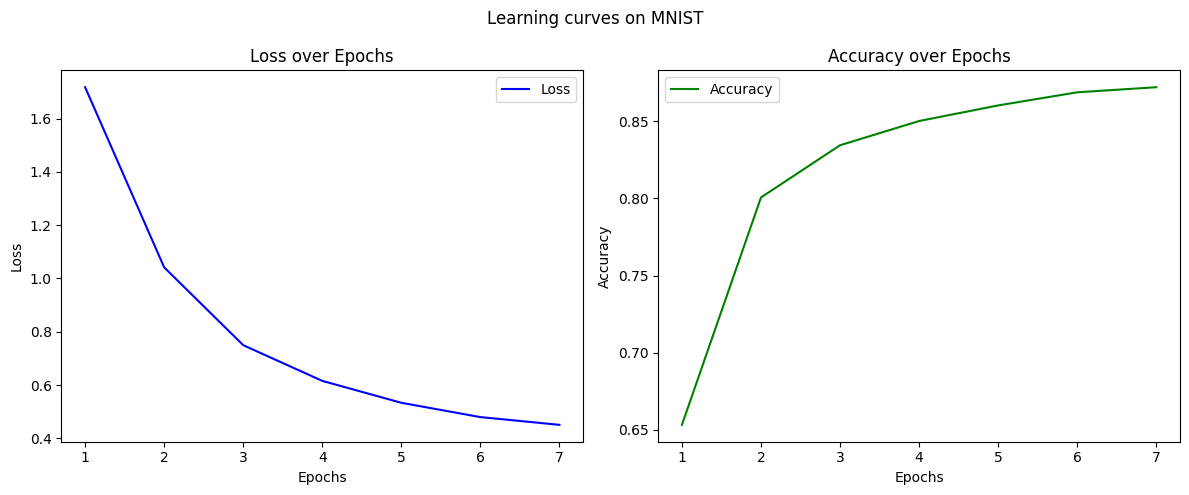

In [ ]:
import math
import gc

gc.collect()

losses, accuracies = train_n_rounds_hybrid(
    pool_mnist,
    T_final=T_FINAL_MIN * 60,
    clients_per_round=math.ceil(len(pool_mnist.clients) * C),
    problem="mnist"
)
plot_loss_accuracy(losses, accuracies, title="Learning curves on MNIST")


Running round: 1 - Time elapsed: 0.0 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Selected clients (S): 72 out of 100
Server selecting data to train centralized...
Number of clients in U: 2
Selected data length (|D_UL|): 307200
Selected clients for this round: 72
Distributing model...
Scheduled model update...
Centralized model update...
Scheduled model upload...


Uploading weights: 100%|█████████▉| 242.89999999999048/242.96002560300286 [04:07<00:00,  1.02s/it]


Aggregating global model...
Server: Test acc: 0.1156, test loss: 2.3023

Running round: 2 - Time elapsed: 286.82188749313354 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Selected clients (S): 71 out of 100
Server selecting data to train centralized...
Number of clients in U: 2
Selected data length (|D_UL|): 307200
Selected clients for this round: 71
Distributing model...
Scheduled model update...
Centralized model update...
Scheduled model upload...


Uploading weights: 100%|█████████▉| 243.89999999999043/243.96578492749654 [04:08<00:00,  1.02s/it]


Aggregating global model...
Server: Test acc: 0.1032, test loss: 2.3026

Running round: 3 - Time elapsed: 571.0529592037201 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Selected clients (S): 73 out of 100
Server selecting data to train centralized...
Number of clients in U: 4
Selected data length (|D_UL|): 377856
Selected clients for this round: 73
Distributing model...
Scheduled model update...
Centralized model update...
Scheduled model upload...


Uploading weights: 100%|█████████▉| 237.3999999999908/237.45475850889406 [04:01<00:00,  1.02s/it]


Aggregating global model...
Server: Test acc: 0.1007, test loss: 2.3026

Running round: 4 - Time elapsed: 849.4086525440216 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Selected clients (S): 73 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Selected data length (|D_UL|): 153600
Selected clients for this round: 73
Distributing model...
Scheduled model update...
Centralized model update...
Scheduled model upload...


Uploading weights: 100%|█████████▉| 241.79999999999055/241.89797177379242 [04:06<00:00,  1.02s/it]


Aggregating global model...
Server: Test acc: 0.1006, test loss: 2.3026

Running round: 5 - Time elapsed: 1125.980177640915 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Selected clients (S): 72 out of 100
Server selecting data to train centralized...
Number of clients in U: 2
Selected data length (|D_UL|): 307200
Selected clients for this round: 72
Distributing model...
Scheduled model update...
Centralized model update...
Scheduled model upload...


Uploading weights: 100%|█████████▉| 242.5999999999905/242.64856707069785 [04:07<00:00,  1.02s/it]


Aggregating global model...
Server: Test acc: 0.1006, test loss: 2.3026

Running round: 6 - Time elapsed: 1406.8590092658997 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Selected clients (S): 71 out of 100
Server selecting data to train centralized...
Number of clients in U: 2
Selected data length (|D_UL|): 307200
Selected clients for this round: 71
Distributing model...
Scheduled model update...
Centralized model update...
Scheduled model upload...


Uploading weights: 100%|█████████▉| 244.79999999999038/244.8875734628154 [04:09<00:00,  1.02s/it]


Aggregating global model...
Server: Test acc: 0.1006, test loss: 2.3026

Running round: 7 - Time elapsed: 1687.627816438675 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Selected clients (S): 73 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Selected data length (|D_UL|): 153600
Selected clients for this round: 73
Distributing model...
Scheduled model update...
Centralized model update...
Scheduled model upload...


Uploading weights: 100%|█████████▉| 239.39999999999068/239.4970505432682 [04:03<00:00,  1.02s/it]


Aggregating global model...
Server: Test acc: 0.1006, test loss: 2.3026
Total selected clients: 505


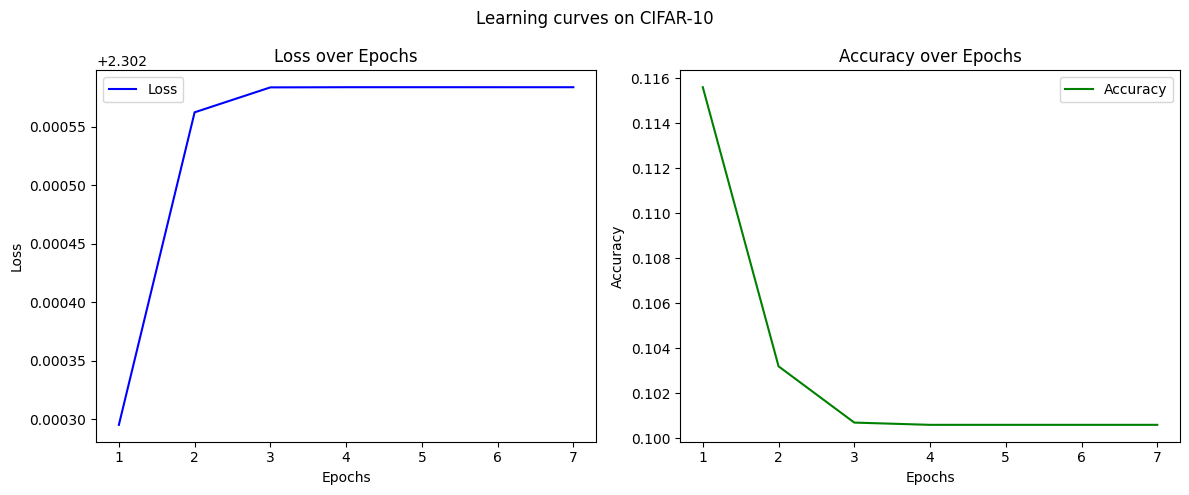

In [ ]:
gc.collect()

losses, accuracies = train_n_rounds_hybrid(
    pool_cifar,
    T_final=T_FINAL_MIN * 60,
    clients_per_round=math.ceil(len(pool_cifar.clients) * C),
    problem="cifar"
)
plot_loss_accuracy(losses, accuracies, title="Learning curves on CIFAR-10")